## Preprocessing

In [30]:
#import libraries
from matplotlib import pyplot as plt
import pandas as pd            
import re
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import spacy

Read train_coffee and train_tea

In [31]:
train_coffee = pd.read_csv('../data/train_coffee.csv')
train_tea = pd.read_csv('../data/train_tea.csv')

### Function to preprocess raw text data

In this part, we tokenize the text as string of words, do necessary pre-processing for these words and put back to one string for each post combine_text.

In [32]:
def text_to_words(raw_text):
    # Function to convert a raw text to a string of words
    # The input is a single string (a raw post text), and 
    # the output is a single string (a preprocessed post text)
    
    # 1. Remove HTML.
    text = BeautifulSoup(raw_text).get_text()

    # 2. remove substrings that start with 'https' or 'http'
    text = re.sub(r"((https)|(http))\S*", "", text)

    # 3. remove substrings that start with 'wwww.'
    text = re.sub(r"www\.\S*", "", text)
    
    # 4. remove substrings with commonly used domains, i.e. '.com', '.net', '.org', '.info'
    text = re.sub(r"(\S(?=.*(\.com|\.net|\.org|\.info))\S*)", "", text)
    
    # 5. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    
    # 6. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 7. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # 8. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 9. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [33]:
def clean_text(df):
    total_texts = df.shape[0]
    print(f'There are {total_texts} texts.')

    # Initialize an empty list to hold the clean reviews.
    clean_data = []
    print("Cleaning and parsing the training set for texts...")

    # Instantiate counter.
    j = 0

    # For every review in our training set...
    for text in df['combine_text']:

        # Convert review to words, then append to clean_train_reviews.
        clean_data.append(text_to_words(text))

        # If the index is divisible by 1000, print a message.
        if (j + 1) % 100 == 0:
            print(f'Texts {j + 1} of {total_texts}.')

        j += 1
    
    return clean_data

### Pre-process coffee and tea post

In [34]:
clean_coffee =clean_text(train_coffee)
clean_coffee

There are 926 texts.
Cleaning and parsing the training set for texts...
Texts 100 of 926.
Texts 200 of 926.
Texts 300 of 926.
Texts 400 of 926.
Texts 500 of 926.
Texts 600 of 926.
Texts 700 of 926.
Texts 800 of 926.
Texts 900 of 926.


['welcome daily r coffee question thread stupid questions ask question get answer start somewhere sometimes hard figure right wrong luckily r coffee community loves help question use specific piece gear want know much coffee use grind sure much water use hot wondering coffee shelf life forget use resources wiki great starter guides wiki guides page wiki gear price page like see coffee gear r coffee members recommend always nice mod daily question thread',
 'welcome r coffee deal promotional thread weekly thread industry folk post upcoming deals promotions companies holding promote new products r coffee subscribers regular users also post deals come across come check roasters coffee related businesses redditors work note thread weekly least duration covid outbreak since many roasters running specials usual drum business encourage everyone post deals especially since many roasters holding specials drive business affected covid outbreak however note zero tolerance shady behavior found act

In [35]:
clean_tea =clean_text(train_tea)
clean_tea

There are 985 texts.
Cleaning and parsing the training set for texts...
Texts 100 of 985.
Texts 200 of 985.
Texts 300 of 985.
Texts 400 of 985.
Texts 500 of 985.
Texts 600 of 985.
Texts 700 of 985.
Texts 800 of 985.
Texts 900 of 985.


['drinking today questions mind stories share worry one make fun drink questions ask also talk anything else mind specific routine making tea oolong kick lately feel free link pictures well even talk non tea related topics maybe want advice guy gal talk life general cup daily discussion questions stories june',
 'realize lots people involved tea industry thread weekly feature anyone promote current projects without worrying self promotion rules feel free include links shop crowdfunding sites surveys sales discount codes rule claims health benefits remains effect go without saying still expect people respectful follow reddiquette intend free promotion zone please overrun thread posting thing marketing monday june',
 'tea testing quality check flavor liquor infusion color third party substance presence testing',
 'hello decided share photo fabulous house forest special atmosphere',
 'little black tea cookies breakfast work florence harney sons',
 'japanese kutani satsuma dragonware obses

### Further data preprocessing 

After we get 'clean' post text, we perform lemmatization for all words to prevent repeated words. We also remove subreddit ('coffee' and 'tea') related words to prevent data leakage to our model.

#### Functions

In [36]:
#  Exclude the words that contain 'tea' or 'coff' 
def filter_term(term):
    if(type(term) != str):
        return False
    if(len(term) < 3):
        return False
    if('tea' in term):
        return False
    if('coffee' in term):
        return False
    return True

In [37]:
# Lemmatize words with Spacy
def lemmatize_func(clean_data):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
    clean_data_refine = []
    
    for c in clean_data:
        doc = nlp(c)
        token_list = [token.lemma_ for token in doc]
        meaningful_words = [i for i in token_list if filter_term(i)]

        string = (" ".join(meaningful_words))
        clean_data_refine.append(string)
    return clean_data_refine

#### further clean for coffee and tea post

In [38]:
clean_coffee_refine = lemmatize_func(clean_coffee)
clean_coffee_refine

['welcome daily question thread stupid question ask question get answer start somewhere sometimes hard figure right wrong luckily community love help question use specific piece gear want know much use grind sure much water use hot wonder shelf life forget use resource wiki great starter guide wiki guide page wiki gear price page like see gear member recommend always nice mod daily question thread',
 'welcome deal promotional thread weekly thread industry folk post upcoming deal promotion company hold promote new product subscriber regular user also post deal come across come check roaster relate business redditor work note thread weekly least duration covid outbreak since many roaster run special usual drum business encourage everyone post deal especially since many roaster hold special drive business affect covid outbreak however note zero tolerance shady behavior find act dishonestly post remove consider ban spot affiliate business please transparent rule business post promotional m

In [39]:
clean_tea_refine = lemmatize_func(clean_tea)

#### find out frequent words

We display top20 words for coffee and tea after applying CountVectorizer and TfidfVectorizer. 

In [40]:
def display_top20_words(text, topic):
    cvec = CountVectorizer()
    tvec = TfidfVectorizer()
    
    words_cvec = pd.DataFrame(cvec.fit_transform(text).todense(),
                       columns=cvec.get_feature_names())
    word_cvec_counts = words_cvec.sum(axis=0)

    # Explore TfidfVectorizer token counts in coffee
    words_tfidf = pd.DataFrame(tvec.fit_transform(text).todense(),
                           columns=tvec.get_feature_names())
    word_counts_tfidf = words_tfidf.sum(axis=0)

    # Plot top 20 words
    plt.figure(figsize=(22,22), facecolor='white')

    plt.subplot(2,2,1)
    word_cvec_counts.sort_values().tail(20).plot(kind='barh')
    #print(word_cvec_counts.sort_values().tail(10))
    plt.title(f'Top 20 Words in {topic}', fontsize=20)
    plt.xlabel('Count', fontsize =15)
    plt.ylabel('Word', fontsize =15)

    plt.subplot(2,2,2)
    word_counts_tfidf.sort_values().tail(20).plot(kind='barh')
    #print(word_counts_tfidf.sort_values().tail(10))
    plt.title(f'Top 20 TFIDF Words in {topic}', fontsize = 20)
    plt.xlabel('TFIDF Value', fontsize =15)
    plt.ylabel('Word', fontsize =15)

    plt.tight_layout()

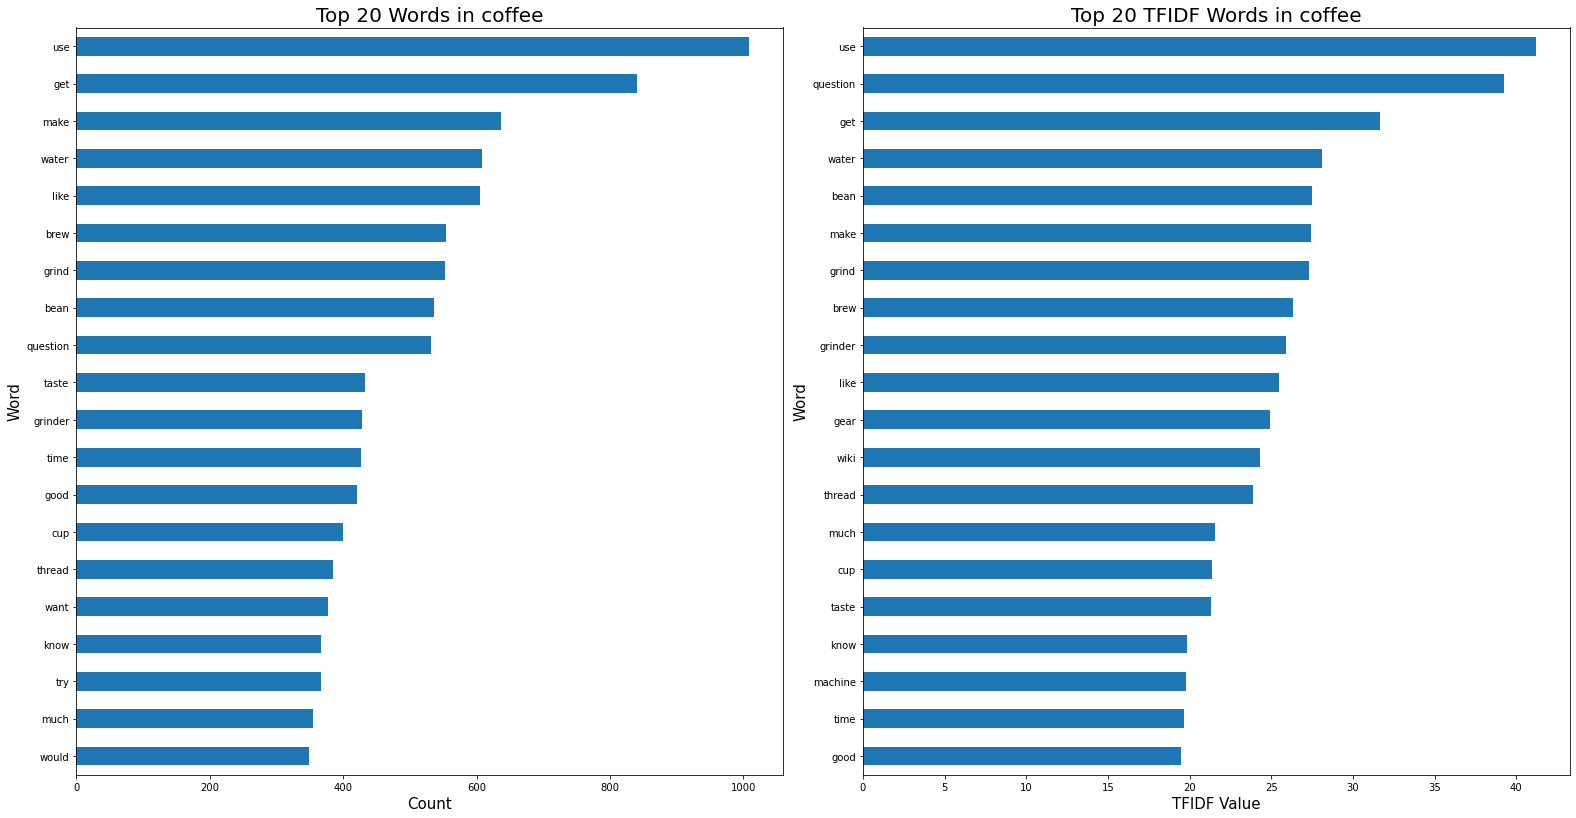

In [41]:
display_top20_words(clean_coffee_refine, 'coffee')

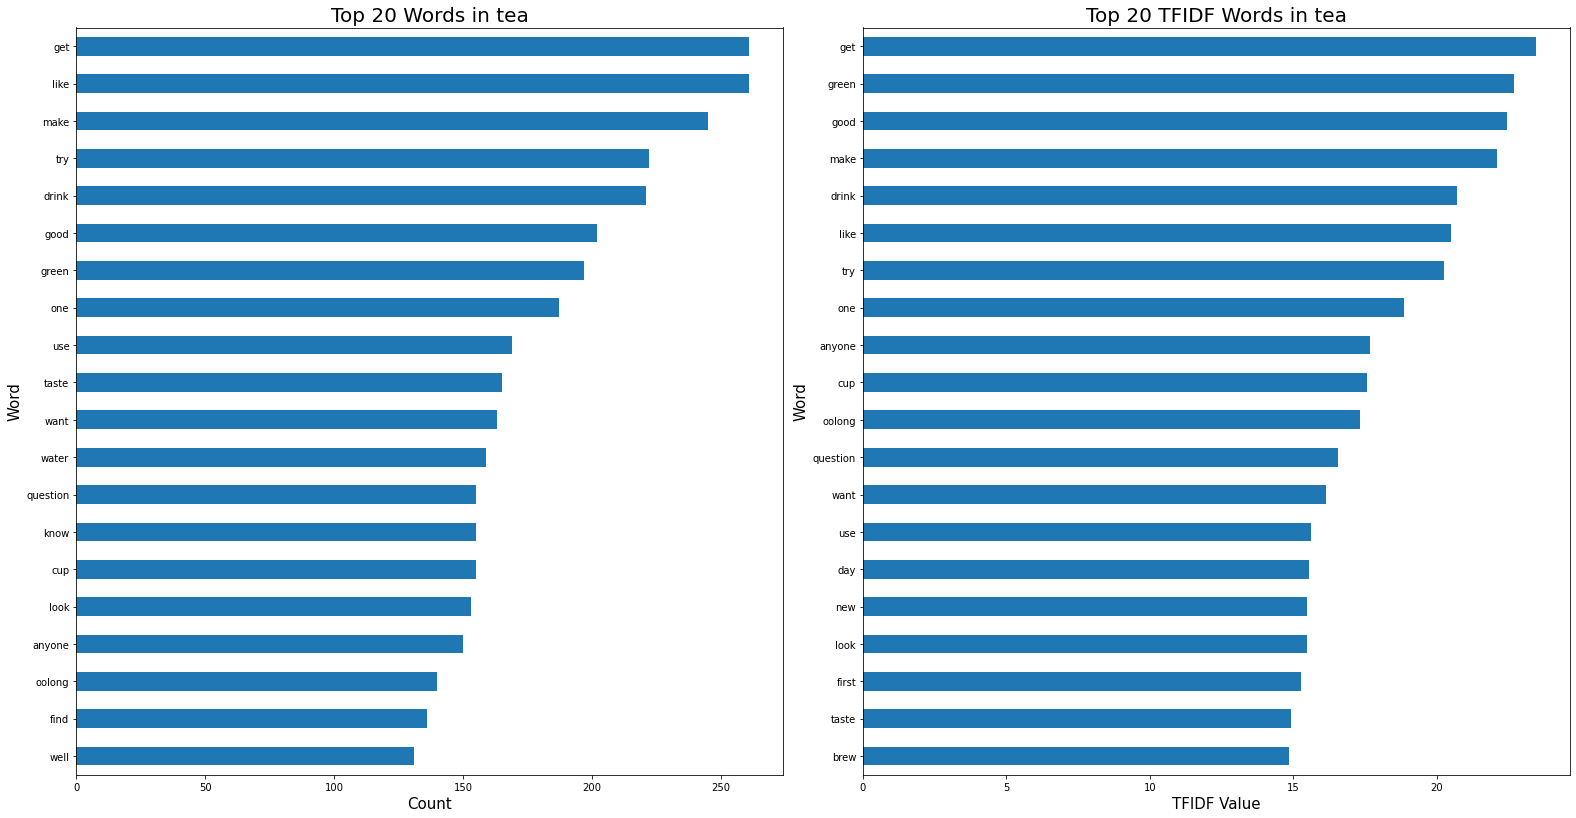

In [42]:
display_top20_words(clean_tea_refine, 'tea')

**Observation**: 
There are quite same words, i.e. 'get', 'make', 'brew', 'water' etc, in both coffee and tea posts. This is expected due to our two subreddit topics are quite similar. However, with similar group of words, it may cause misclassification for our model. 

In [43]:
# Save final clean text to train dataframe for both coffee and tea.
train_coffee['clean_combine'] = clean_coffee_refine

In [44]:
train_tea['clean_combine'] = clean_tea_refine

#### Combine train_coffee and train_tea to prepare modeling.

In [45]:
# concatenate train_coffee and train_tea as train_combine
train_combine= pd.concat([train_coffee, train_tea], ignore_index=True)

In [46]:
# create one column in which 1 if 'subreddit' is 'coffee' and 0 else
train_combine['is_coffee'] = [1 if i == 'Coffee' else 0 for i in train_combine['subreddit']]

In [47]:
# save train_combine to csv for modeling
train_combine.to_csv('../data/train_combine.csv', index = False)